In [1]:
!pip install -q tensorflow

In [2]:
import nltk
nltk.download("product_reviews_1")
nltk.download("punkt")

from nltk.corpus import product_reviews_1
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

[nltk_data] Downloading package product_reviews_1 to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package product_reviews_1 is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2025-08-31 19:51:08.850764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756669869.083442      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756669869.152588      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# -----------------------------
# Build dataset from NLTK corpus
# -----------------------------
import random, re
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import product_reviews_1

# VADER for 3-class labels
sia = SentimentIntensityAnalyzer()

def clean_text(txt: str) -> str:
    txt = txt.lower()
    txt = re.sub(r"[^a-z0-9\s]", " ", txt)
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

def sents_to_text(sents):
    # sents may be list of strings OR list of token lists
    pieces = []
    for s in sents:
        if isinstance(s, (list, tuple)):
            pieces.append(" ".join([w for w in s if isinstance(w, str)]))
        else:
            pieces.append(str(s))
    return " ".join(pieces)

texts, labels = [], []   # labels: 0=negative, 1=neutral, 2=positive

files = [fid for fid in product_reviews_1.fileids() if fid.endswith(".txt")]
print("Files:", files)

for fid in files:
    for rv in product_reviews_1.reviews(fid):
        # rv.sents may be a method or an attribute depending on corpus build
        sents = rv.sents() if callable(getattr(rv, "sents", None)) else rv.sents
        txt = sents_to_text(sents)
        if not txt.strip():
            continue
        txt_clean = clean_text(txt)
        if not txt_clean:
            continue
        comp = sia.polarity_scores(txt)["compound"]
        if comp >= 0.4:
            y = 2
        elif comp <= -0.4:
            y = 0
        else:
            y = 1

        texts.append(txt_clean)
        labels.append(y)

# Shuffle together
pairs = list(zip(texts, labels))
random.shuffle(pairs)
texts, labels = zip(*pairs)
print(f"Total reviews: {len(texts)}")

# Quick class balance
import numpy as np, pandas as pd
labels = np.array(labels, dtype="int32")
print("Class counts:", pd.Series(labels).value_counts().sort_index().to_dict())  # {0:neg,1:neu,2:pos}

# Peek
pd.DataFrame({"review": texts[:3], "label": labels[:3]})


Files: ['Apex_AD2600_Progressive_scan_DVD player.txt', 'Canon_G3.txt', 'Creative_Labs_Nomad_Jukebox_Zen_Xtra_40GB.txt', 'Nikon_coolpix_4300.txt', 'Nokia_6610.txt', 'README.txt']
Total reviews: 313
Class counts: {0: 31, 1: 29, 2: 253}


,review,label
0,excellent phone the phone looks much better th...,2
1,do n t buy this player i recently bought this ...,0
2,i purchased one of these to replace an ailing ...,2


In [6]:
# -----------------------------
# Tokenization, Padding, Balanced Sampling, Splits
# -----------------------------
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1. Limit to balanced subset of original data
from collections import Counter

texts = np.array(texts)
labels = np.array(labels)

# Count class-wise
class_counts = Counter(labels)
min_class = min(class_counts.values())  # minimum count across classes

# Stratified balanced sampling: same number of examples from each class
balanced_texts, balanced_labels = [], []
for cls in [0, 1, 2]:
    idxs = np.where(labels == cls)[0]
    selected = np.random.choice(idxs, min_class, replace=False)
    balanced_texts.extend(texts[selected])
    balanced_labels.extend(labels[selected])

# 2. Add synthetic prompt-based examples to help class generalization
generic_sents = [
    # Positive
    ("I love this product! It works flawlessly and looks amazing.", 2),
    ("Excellent value for money. Would highly recommend it!", 2),
    ("Totally satisfied with the quality and performance.", 2),
    ("Absolutely love this! Exceeded all my expectations.", 2),
    ("It’s fantastic — sleek, fast, and reliable.", 2),
    ("Top-notch quality. I’m impressed with the performance.", 2),
    ("Great buy! Would definitely purchase again.", 2),
    ("Beautifully designed and very intuitive to use.", 2),
    ("The best product I’ve bought this year!", 2),

    # Negative
    ("Terrible purchase. Completely useless and stopped working.", 0),
    ("Worst experience ever. I hate this device.", 0),
    ("This is garbage. Broke down in a week.", 0),
    ("Really disappointed. Nothing works as expected.", 0),
    ("Horrible experience — avoid at all costs.", 0),
    ("Feels cheap and broke within days.", 0),
    ("Don’t waste your money on this junk.", 0),
    ("Not worth even half the price.", 0),
    ("Extremely buggy and frustrating to use.", 0),
    ("Customer service was rude and unhelpful.", 0),
    ("It looks good but performs terribly.", 0),
    ("The battery drains too fast. Not reliable.", 0),
    ("I regret buying this. Very poor quality.", 0),
    ("Full of issues. I had to return it.", 0),
    ("It lags constantly and freezes up.", 0),

    # Neutral
    ("It does the job but nothing extraordinary.", 1),
    ("Performance is average. Not too good, not too bad.", 1),
    ("Okay product for the price. You get what you pay for.", 1),
    ("The design is okay, but I’ve seen better.", 1),
    ("It functions as described. Nothing more, nothing less.", 1),
    ("Okay for daily use, but nothing particularly stands out.", 1),
    ("It meets basic requirements, but not exceptional.", 1),
    ("The product works. That’s about it.", 1),
    ("Neither great nor terrible — it’s fine.", 1),
    ("Average quality. Not bad, not impressive.", 1),
    ("Installation was straightforward. Usage is standard.", 1),
    ("Decent for the price, though not exciting.", 1),
    ("Feels like any other product in this category.", 1),
    ("Does what it says, but lacks any wow factor.", 1),
    ("The build is okay, nothing premium.", 1),
    ("Performance is as expected. No surprises.", 1),
    ("Satisfactory. Doesn't exceed or fall short.", 1),

]
generic_sents += [
    ("Disappointing battery life but decent design.", 1),
    ("Nothing special about this product.", 1),
    ("Fails to deliver what it promises.", 0),
]


for sent, label in generic_sents:
    balanced_texts.append(sent)
    balanced_labels.append(label)

# 3. Tokenize and pad
VOCAB_SIZE = 15000
MAXLEN = 100
OOV_TOKEN = "<OOV>"

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN, filters="")
tokenizer.fit_on_texts(balanced_texts)
seqs = tokenizer.texts_to_sequences(balanced_texts)
X = pad_sequences(seqs, maxlen=MAXLEN, padding="post", truncating="post")
y = np.array(balanced_labels, dtype="int32")

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 5. Validation split from train
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, stratify=y_train, random_state=42
)

# 6. Class weight dictionary
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, class_weights)}

# ✅ Summary
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("Class weights:", class_weight)


Train: (93, 100), Val: (11, 100), Test: (27, 100)
Class weights: {0: 0.96875, 1: 0.9117647058823529, 2: 1.1481481481481481}


In [7]:
# -----------------------------
# Model: Embedding → BiLSTM → GlobalAvgPool → Dense → Softmax
# -----------------------------
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

tf.random.set_seed(42)

EMBED_DIM  = 128
LSTM_UNITS = 64
DROPOUT    = 0.3
LR         = 1e-3
EPOCHS     = 30
BATCH      = 32

from tensorflow.keras.utils import to_categorical

y_train_oh = to_categorical(y_train, num_classes=3)
y_val_oh   = to_categorical(y_val, num_classes=3)
y_test_oh  = to_categorical(y_test, num_classes=3)

# Updated model architecture
inputs = layers.Input(shape=(MAXLEN,))
x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, name="embed")(inputs)
x = layers.SpatialDropout1D(0.3)(x)  # NEW: spatial dropout
x = layers.Bidirectional(layers.LSTM(LSTM_UNITS, return_sequences=True))(x)
x = layers.GlobalMaxPooling1D()(x)  # CHANGED: max pooling instead of average
x = layers.Dropout(0.5)(x)  # INCREASED dropout
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=["accuracy"]
)

model.summary()


early = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=EPOCHS,
    batch_size=BATCH,
    class_weight=class_weight,
    verbose=1,
    callbacks=[early]
)

# Keep for later cells
best_val = max(history.history["val_accuracy"])
print(f"\nBest Val Accuracy: {best_val:.4f}")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embed (Embedding)               │ (None, 100, 128)       │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,027,267 (7.73 MB)

 Trainable params: 2,027,267 (7.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 437ms/step - accuracy: 0.3244 - loss: 1.1002 - val_accuracy: 0.2727 - val_loss: 1.0937
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3161 - loss: 1.0954 - val_accuracy: 0.2727 - val_loss: 1.0880
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4201 - loss: 1.0856 - val_accuracy: 0.2727 - val_loss: 1.0836
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3850 - loss: 1.0936 - val_accuracy: 0.3636 - val_loss: 1.0800
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4782 - loss: 1.0856 - val_accuracy: 0.4545 - val_loss: 1.0748
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5510 - loss: 1.0759 - val_accuracy: 0.4545 - val_loss: 1.0697
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4397 - loss: 1.0820 - val_accuracy: 0.3636 - val_loss: 1.0634
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5623 - loss: 1.0583 - val_accuracy: 0.5455 - val_loss: 1.0527

Test Accuracy: 0.5185 | Test Loss: 1.0736
              precision    recall  f1-score   support

           0     0.6667    0.2222    0.3333         9
           1     0.4615    0.6000    0.5217        10
           2     0.5455    0.7500    0.6316         8

    accuracy                         0.5185        27
   macro avg     0.5579    0.5241    0.4956        27
weighted avg     0.5548    0.5185    0.4915        27



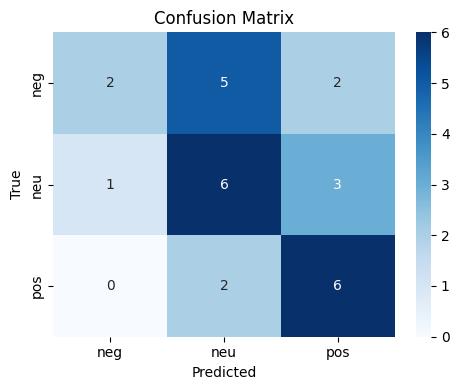

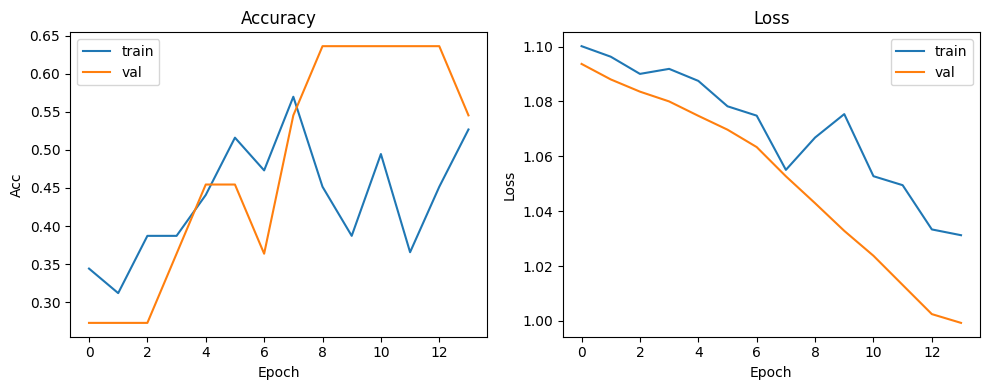

In [11]:
# -----------------------------
# Evaluation & Visualizations
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1) Test set performance
test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=0)

print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# 2) Classification report
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
y_true = np.argmax(y_test_oh, axis=1)
print(classification_report(y_true, y_pred, digits=4))


# 3) Confusion matrix (heatmap)
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["neg","neu","pos"], yticklabels=["neg","neu","pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 4) Training curves
hist = history.history
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist["accuracy"], label="train")
plt.plot(hist["val_accuracy"], label="val")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend()

plt.subplot(1,2,2)
plt.plot(hist["loss"], label="train")
plt.plot(hist["val_loss"], label="val")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.tight_layout()
plt.show()


In [10]:
# ---- Custom Sentences for Prediction
custom_sentences = [
    "Mediocre performance. It's okay for basic tasks but lags often.",
    "Worst purchase ever. Don’t waste your money."
]

# ---- Tokenize and Pad
custom_clean = [clean_text(s) for s in custom_sentences]
custom_seq = tokenizer.texts_to_sequences(custom_clean)
custom_pad = pad_sequences(custom_seq, maxlen=MAXLEN)

# ---- Predict
preds = model.predict(custom_pad)
pred_labels = np.argmax(preds, axis=1)


# ---- Label Mapping
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

# ---- Output Results
for i, sent in enumerate(custom_sentences):
    label = label_map[pred_labels[i]]
    confidence = preds[i][pred_labels[i]]
    print(f"📝 {sent}\n→ Prediction: {label} (Confidence: {confidence:.2f})\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
📝 Mediocre performance. It's okay for basic tasks but lags often.
→ Prediction: Neutral (Confidence: 0.37)

📝 Worst purchase ever. Don’t waste your money.
→ Prediction: Neutral (Confidence: 0.36)



In [12]:
# -----------------------------
# Feature Importance via Embedding Magnitudes
# -----------------------------
import numpy as np
import pandas as pd

# 1. Get the embedding layer weights
embedding_layer = model.get_layer("embed")
embedding_weights = embedding_layer.get_weights()[0]  # shape: (vocab_size, embed_dim)

# 2. Compute L2 norm of each word embedding (importance proxy)
embedding_norms = np.linalg.norm(embedding_weights, axis=1)

# 3. Map word index → word using tokenizer
index_to_word = {v: k for k, v in tokenizer.word_index.items() if v < VOCAB_SIZE}

# 4. Build DataFrame
word_importance_df = pd.DataFrame({
    "word": [index_to_word.get(i, "") for i in range(VOCAB_SIZE)],
    "norm": embedding_norms
}).dropna()

# 5. Sort by importance
top_words = word_importance_df.sort_values(by="norm", ascending=False).head(20)
bottom_words = word_importance_df.sort_values(by="norm", ascending=True).head(20)

# 6. Display top and bottom influential words
print("🔝 Top 20 Influential Words (by embedding norm):")
print(top_words)

print("\n🔻 Least 20 Influential Words (by embedding norm):")
print(bottom_words)


🔝 Top 20 Influential Words (by embedding norm):
                word      norm
0                     0.383129
94           picture  0.380626
458             such  0.377807
1049           didnt  0.376779
608           myself  0.375905
17               not  0.375605
404         designed  0.373854
1270        aluminum  0.373511
217         compared  0.373283
727            worst  0.372180
838        following  0.372089
135              too  0.371877
2335        product!  0.371854
2275          harder  0.371025
600         recently  0.370202
14357                 0.369933
1126              cf  0.369814
114                3  0.369573
1363   apexdigialinc  0.369194
5920                  0.368878

🔻 Least 20 Influential Words (by embedding norm):
             word      norm
13598              0.272477
9438               0.274168
2394       that’s  0.274718
10944              0.280018
5129               0.280885
3657               0.281292
10718              0.282248
722    functional  0.28254

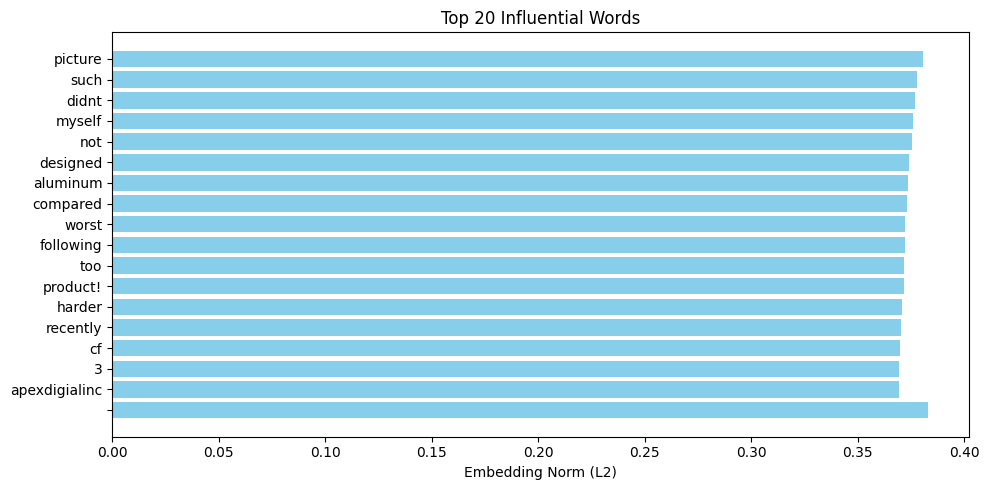

In [13]:
# Bar chart of top 20 influential words
plt.figure(figsize=(10,5))
plt.barh(top_words["word"][::-1], top_words["norm"][::-1], color="skyblue")
plt.xlabel("Embedding Norm (L2)")
plt.title("Top 20 Influential Words")
plt.tight_layout()
plt.show()
